# Viscous Burgers equation
Jared Callaham (2020)

$$ u_t + u u_x = \nu u_{xx} $$
This 1D PDE is a model for shock formation. The inviscid version with $\nu = 0$ forms discontinuous shocks; one way to avoid this is to introduce a small dissipative term. Over most of the field the curvature is small enough that this term is presumed to be negligible. However, when the shock begins to form the second derivative becomes large and the viscosity is important.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(12, 8))
%config InlineBackend.figure_format = 'retina'

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA

"""# Optionally, set cluster zero to white
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm = plt.get_cmap('Set1')
new_cm = cm(np.arange(cm.N))
new_cm[0, :] = [1, 1, 1, 1]
cm_white = ListedColormap(new_cm)"""

# Seaborn colormap
import seaborn as sns
from matplotlib.colors import ListedColormap
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

### Load data and visualize the field

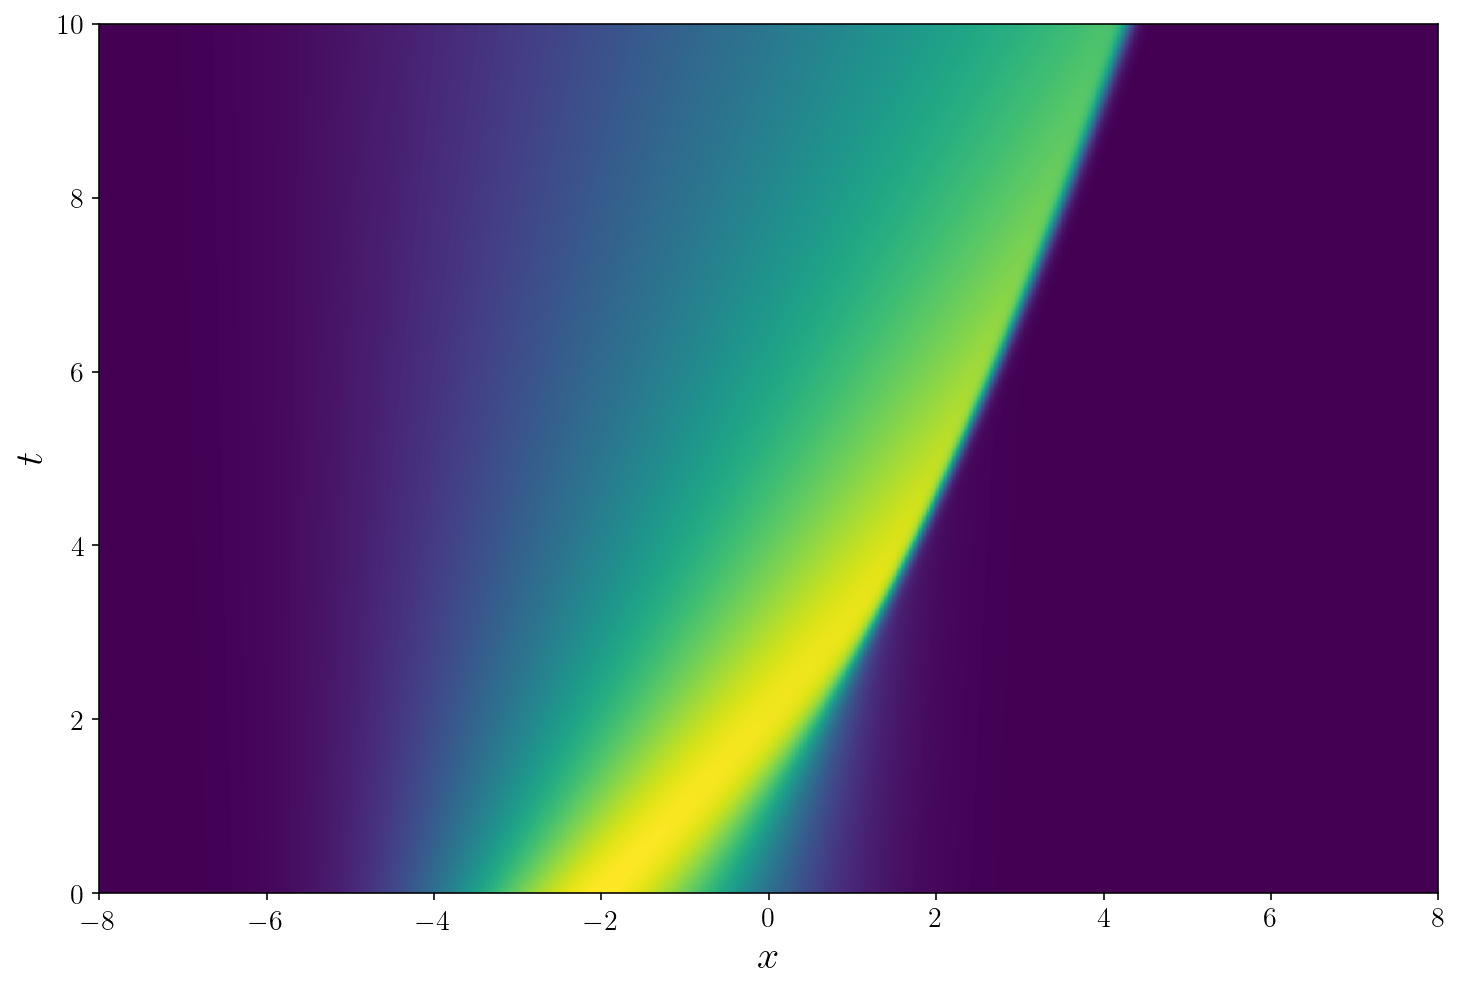

In [20]:
data = sio.loadmat('../data/burgers.mat')

t = data['t'][:, 0]
x = data['x'][0, :]
u = data['u']

# Viscosity
nu = 0.02

plt.figure()
plt.pcolor(x, t, u.T, cmap='viridis')
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.show()

### Compute "features"

Each feature for the clustering is one term in the model - equivalently, coordinates in the equation space.

Here we'll just use finite differences to estimate these terms.

In [21]:
ux = np.zeros(u.shape)
uxx = np.zeros(u.shape)

dx = x[1] - x[0]
dt = t[1] - t[0]
N = len(x)

# Finite difference derivatives in space
for x_idx in range(1, N-1):
    ux[x_idx, :] = (u[x_idx+1, :] - u[x_idx-1, :])/(2*dx)
    uxx[x_idx, :] = (u[x_idx+1, :] -2*u[x_idx, :] +u[x_idx-1, :])/dx**2
    
uux = u*ux # Advection term
    
# Finite difference derivatives in time
ut = np.zeros(u.shape)
ut[:, 0] = (u[:, 1] - u[:, 0])/dt
ut[:, -1] = (u[:, -1] - u[:, -2])/dt
for t_idx in range(1, u.shape[1]-1):
    ut[:, t_idx] = (u[:, t_idx+1] - u[:, t_idx-1])/(2*dt)

### 1. Equation space representation

The representation of the field in equation space, where each term is one coordinate, can be visualized with a simple scatter plot.  In this case the equation has three terms, so equation space is three-dimensional.  We plot with 2D slices of the space. If a dominant balance exists between a subset of the terms, we expect the equation space coordinates to be near zero for the inactive terms in that region.

Note that the known coefficients are included in the feature (as opposed to a regression-type scheme).  This helps with the numerics and is a more natural representation, so that all the features should approximately balance.

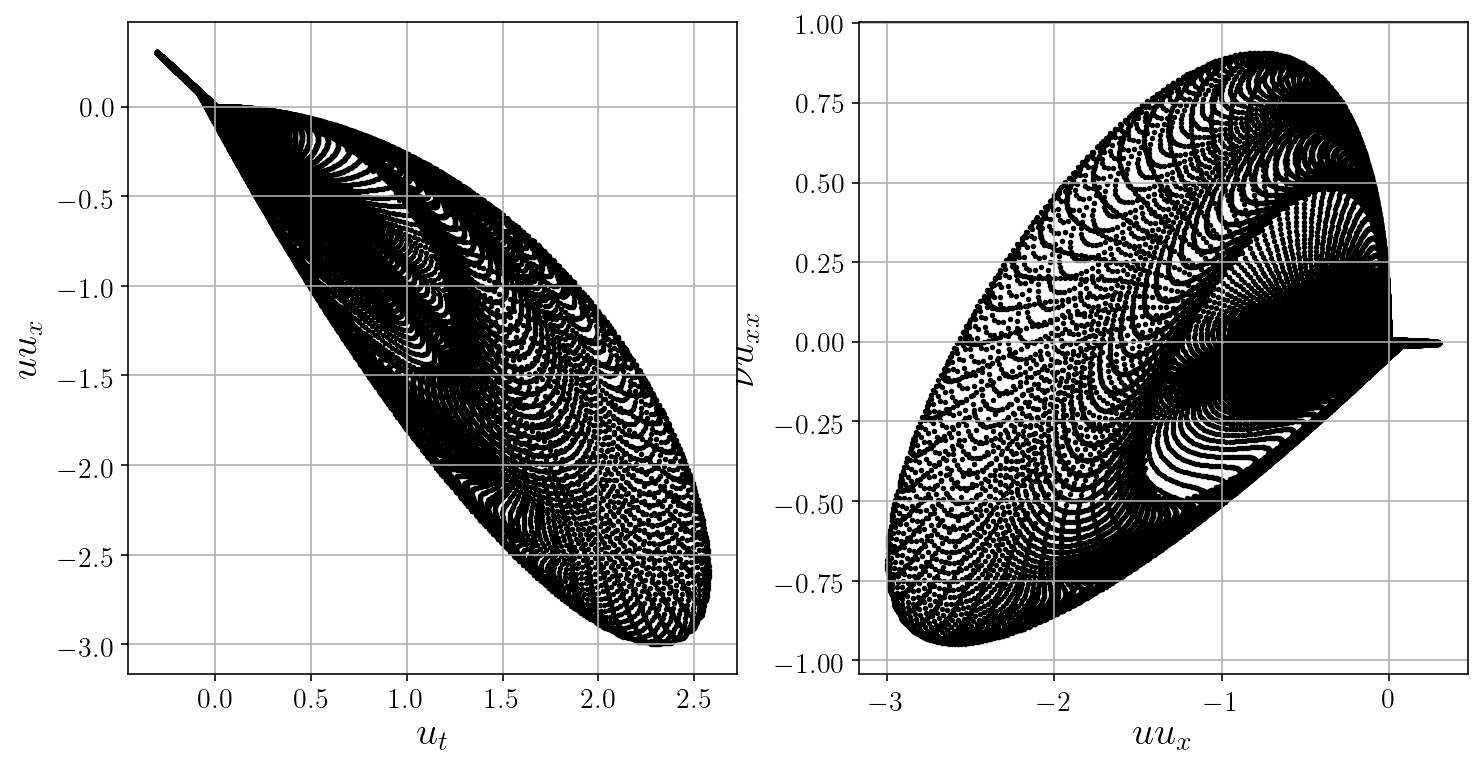

In [22]:
# features are [acceleration, advection, viscous]
features = np.vstack([ut.flatten(), uux.flatten(), nu*uxx.flatten()]).T
nfeatures = features.shape[1]
labels = ['$u_t$', '$u u_x$', r'$\nu u_{xx}$']

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(features[:, 0], features[:,1], 3, 'k')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()

plt.subplot(122)
plt.scatter(features[:, 1], features[:,2], 3, 'k')
plt.xlabel(labels[1])
plt.ylabel(labels[2])
plt.grid()

plt.show()

To some extent we can already interpret the results by eye; there is a group of points close to zero in the viscous direction.  We might expect these points to correspond to the field away from the shock region, while the large spread of points which do vary in the viscous direction would encompass the shock.

### 2. Train Gaussian mixture model

The Gaussian mixture model separates the points into clusters with different means and covariance matrices.  Although there is no sparsification built into the procedure, we might hope that the algorithm identifies a cluster approximately restricted to the $\left\{u_t, uu_x\right\}$ plane and another that captures the viscosity of the shock.

The GMM is just trained with an off-the-shelf `scikit-learn` algorithm. Number of clusters is a tuning parameter - see discussion in paper text for suggestions on how to choose this.

In [23]:
nc = 4  # Number of clusters

#seed = np.random.randint(2**32)
seed = 764176133  # Random seed (for reproducible plots)
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed)
model = GaussianMixture(n_components=nc)

model.fit(features)

764176133


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

One advantage of the Gaussian mixture model is that the covariance matrices can be accessed and have a direct physical interpretation. Directions with significant variance indicate active physical terms in that region.  So for example clusters 1 and 2 have near-zero variance in the viscous direction, as anticipated.

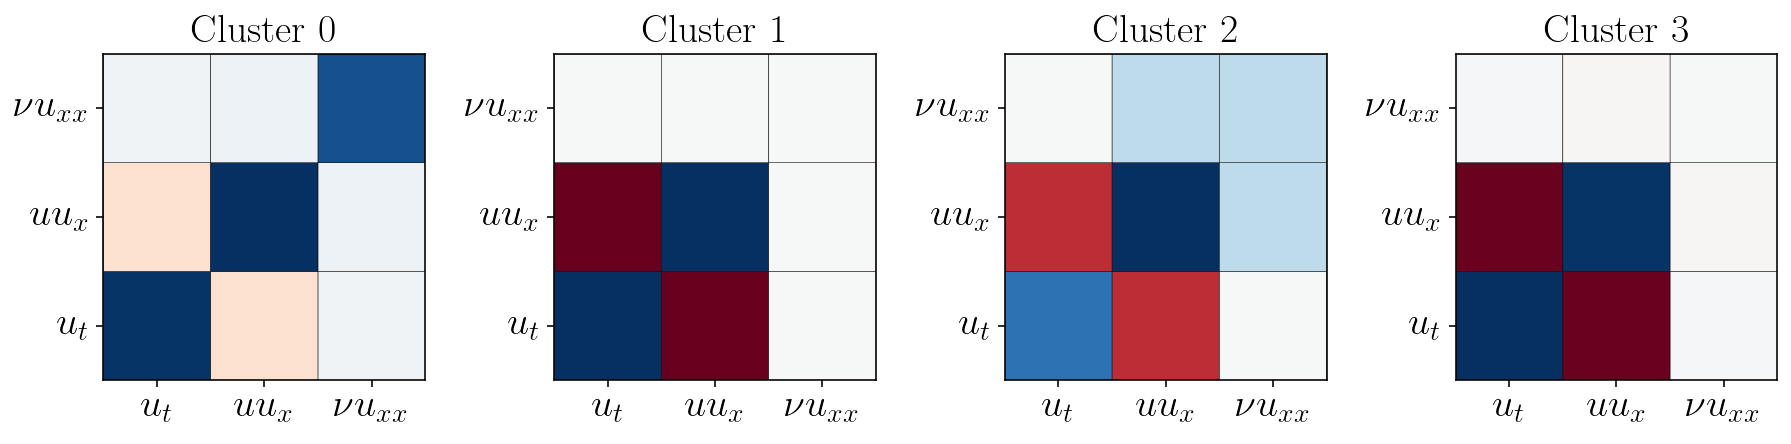

In [24]:
# Plot covariance matrices
plt.figure(figsize=(15, 3))
for i in range(nc):
    plt.subplot(1, 4, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu', edgecolors='k')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels, fontsize=20)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticklabels(labels, fontsize=20)
    plt.gca().set_title('Cluster {0}'.format(i))
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

Color-coding the equation space visualization also gives some intuition about the clusters

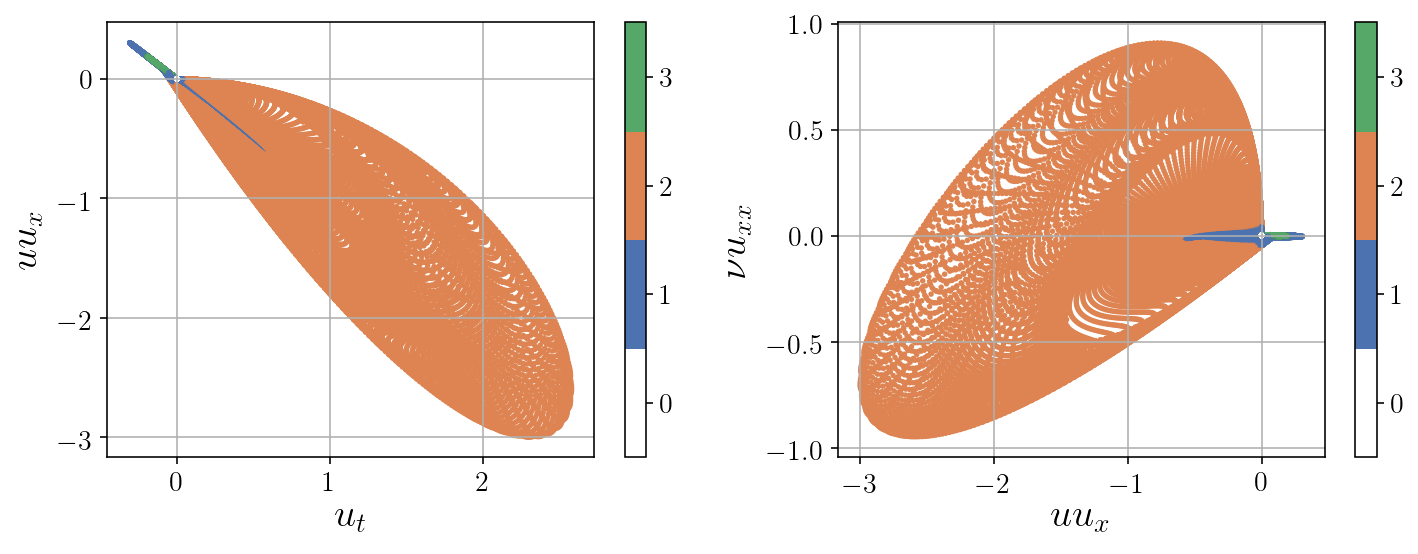

In [25]:
cluster_idx = model.predict(features)
s = 3

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(features[:, 0], features[:,1], s, cluster_idx, cmap=cm)
plt.ylabel('$u u_x$')
plt.xlabel('$u_t$')
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(-0.5, nc+0.5), ticks=np.arange(0, nc))
plt.grid()

plt.subplot(122)
plt.scatter(features[:, 1], features[:,2], s, cluster_idx, cmap=cm)
plt.ylabel(r'$\nu u_{xx}$')
plt.xlabel('$u u_x$')
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(-0.5, nc+0.5), ticks=np.arange(0, nc))
plt.grid()

Similarly, we can plot a colormap of the GMM clusters.  The algorithm identifies contiguous spatiotemporal regions, even though this is not enforced in any way.

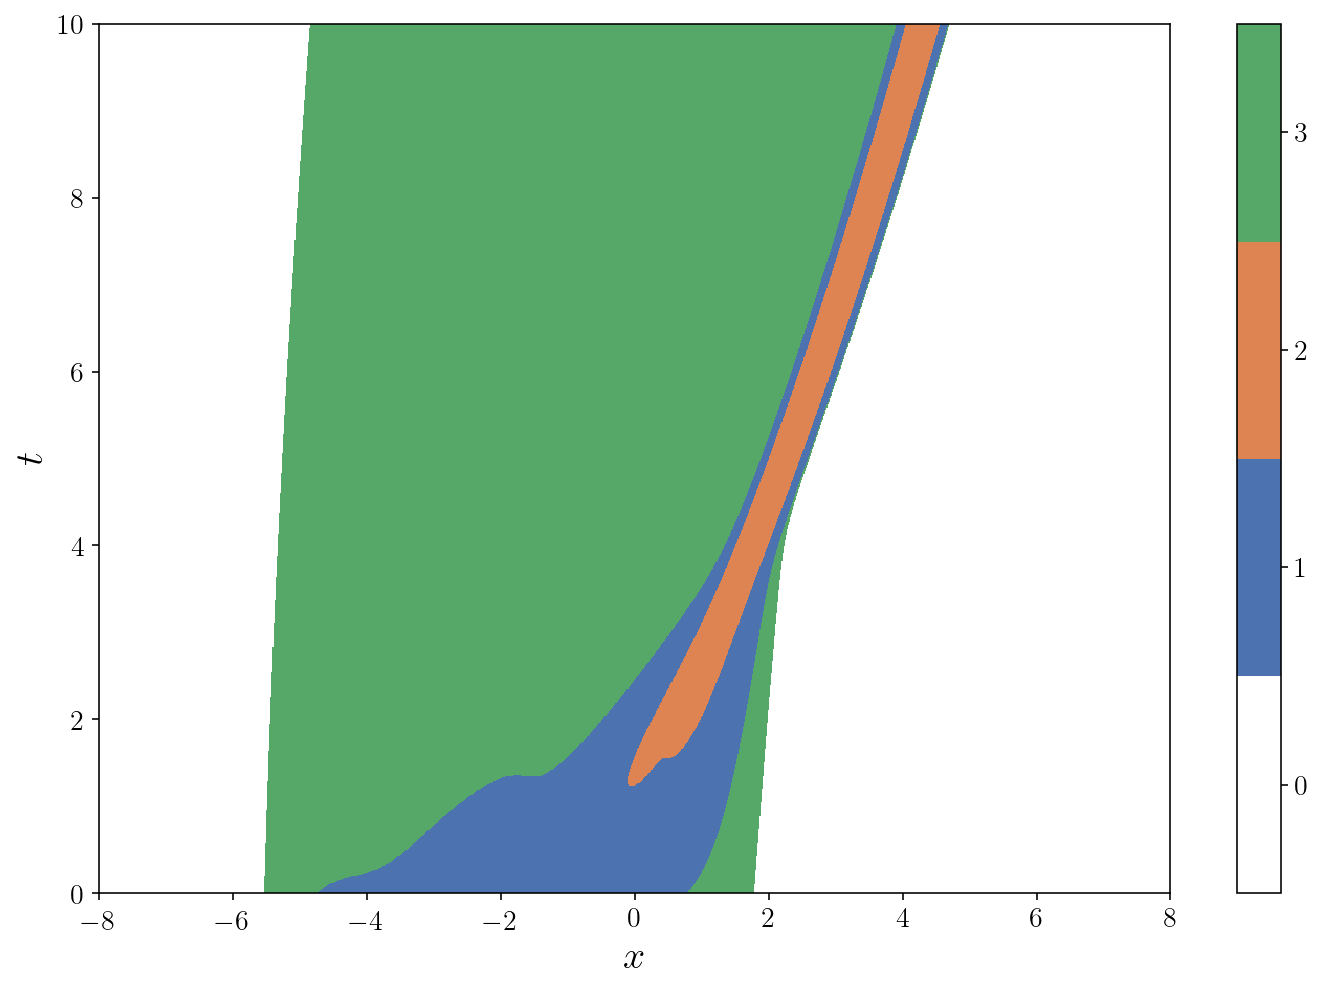

In [26]:
# Colormap of clusters in entire domain
clustermap = np.reshape(cluster_idx, [len(x), len(t)])

plt.figure()
plt.pcolor(x, t, clustermap.T, vmin=-0.5, vmax=cm.N-0.5, cmap=cm)
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.colorbar(boundaries=np.arange(-0.5, nc+0.5), ticks=np.arange(0, nc))
#plt.xlim([-0.3, 2])
#plt.ylim([0, 0.04])
plt.show()

### 3. Sparse principal components analysis (SPCA)

Although the covariance matrices contain the information we want to some extent, there is no sparsity promotion in the Gaussian mixture model fitting procedure, so the matrices are in general dense.  In addition, since the data typically follows non-Gaussian distributions, there are often redundant clusters which are necessary to sufficiently segment the data (clusters 1 and 2 above, for example).

Both of these can be addressed simultaneously with SPCA, which solves the PCA problem with an additional $\ell_1$ regularization.  We apply this to each GMM cluster individually.  For clusters representing a dominant balance, we expect the leading sparse principal component to have nonzero entries only in the directions corresponding to active terms.  For example, GMM clusters 1 and 2 above are most likely well-represented by a single principal component which has zero entries in the direction corresponding to viscosity.

In this case the tuning parameter is the weight of the $\ell_1$ regularization ($\alpha$ here and in the `scikit-learn` notation). An easy way to choose this value is to sweep across a range of regularizations and compute the norm of the excluded terms.  When the system is over-regularized, important terms are discarded and this residual becomes large.  This is a kind of Pareto curve; the appropriate $\alpha$ value is then the largest before the residual begins to grow.

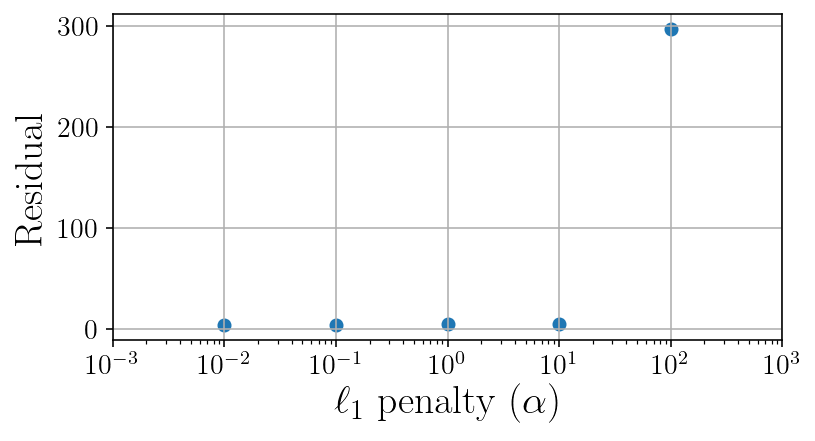

In [27]:
alphas = [1e-2, 1e-1, 1, 1e1, 1e2]  # L1 regularization terms
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        # Fit the SPCA model using only the points in this GMM cluster
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k], normalize_components=True)
        spca.fit(cluster_features)
        
        # Find directions in equation space with nonzero variance for the first principal component
        #   (These correspond to active terms in this region)
        active_terms = np.nonzero(spca.components_[0])[0]
        
        # The residual is defined as the norm of what was discarded
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ penalty ($\alpha$)')
plt.ylabel('Residual')
plt.gca().set_xscale('log')
plt.xlim([1e-3, 1e3])
plt.grid()
plt.show()

In this case the choice is obvious: $\alpha=10$.  We redo the SPCA with this regularization value and print the active terms in each cluster

In [28]:
alpha_opt = 10

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')
        

GMM Cluster 0:
None
GMM Cluster 1:
['$u_t$', '$u u_x$']
GMM Cluster 2:
['$u_t$', '$u u_x$', '$\\nu u_{xx}$']
GMM Cluster 3:
['$u_t$', '$u u_x$']


### 4. Final balance models
As expected, there are some redundant clusters now.  We can reduce the clustering by combining clusters with the same sparsity pattern in their principal components into a single "balance model"

[[0. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]
SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['$u_t$', '$u u_x$']
SPCA Cluster 2:
['$u_t$', '$u u_x$', '$\\nu u_{xx}$']


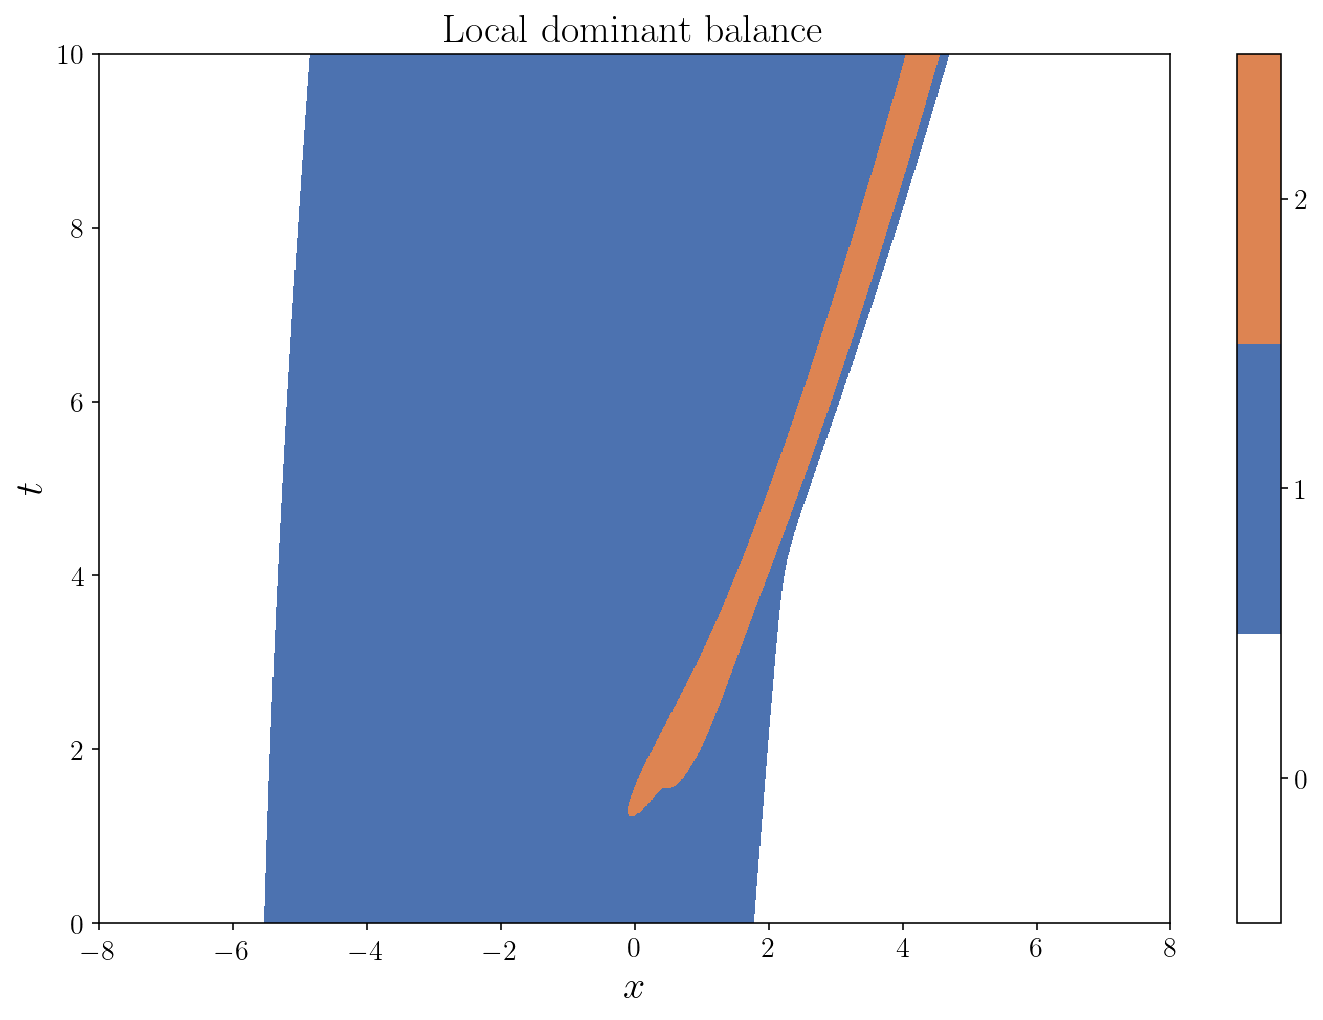

In [29]:
# balance_models has ones for active terms in each model
# model_index maps from GMM identification to the SPCA model
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print active terms in each balance model
for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: print('No dynamics')

# To plot the field, make a map where each location is tagged with the corresponding balance model
# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [len(x), len(t)])

plt.figure()
plt.pcolor(x, t, balancemap.T, vmin=-0.5, vmax=cm.N-0.5, cmap=cm)
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.title('Local dominant balance')
plt.show()

A nice way to see what is active where

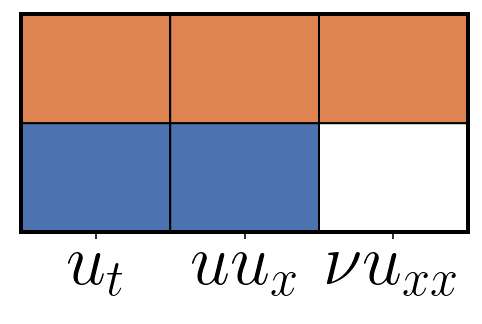

In [30]:
gridmap = balance_models.copy()
#gridmap[gridmap==0] = np.NaN
gridmap = (gridmap.T*np.arange(nmodels)).T  # Scale map so that active terms can be color-coded

plt.figure(figsize=(4, 2))
plt.pcolor(gridmap[1:, :], vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=36)
#plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
#plt.gca().set_yticklabels(range(nc), fontsize=20)
plt.gca().set_yticks([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
    
plt.show()

Again, we can check the equation space representation to be sure this is consistent with our understanding of the physics involved

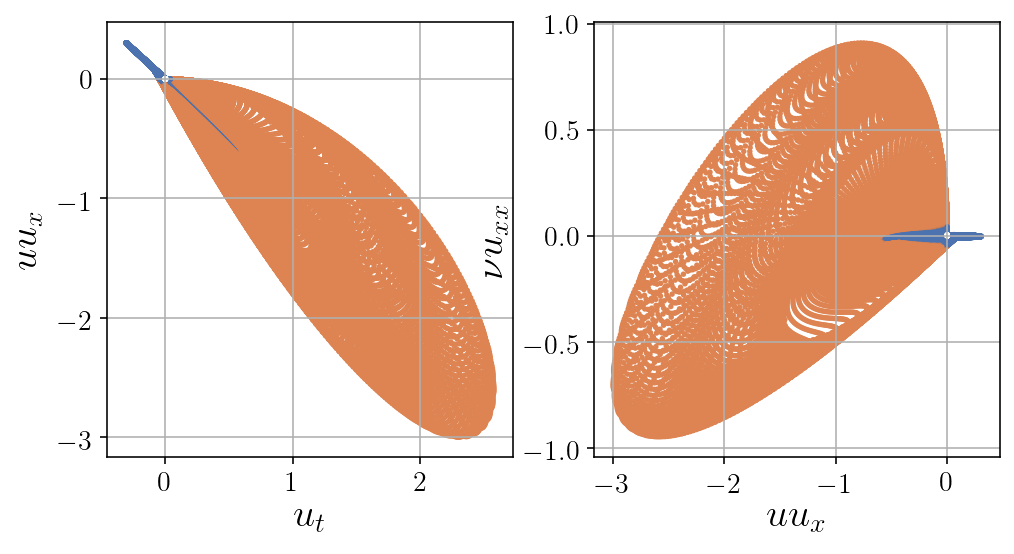

In [13]:
fontsize=20
s = 3

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features[:, 0], features[:,1], s, balance_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[1], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.grid()

plt.subplot(122)
plt.scatter(features[:, 1], features[:,2], s, balance_idx, cmap=cm)
plt.ylabel(labels[2], fontsize=fontsize)
plt.xlabel(labels[1], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.grid()


plt.show()

To see in detail that the viscous term is only highlighted along the shock, we can cluster and plot a single snapshot in time

3.0


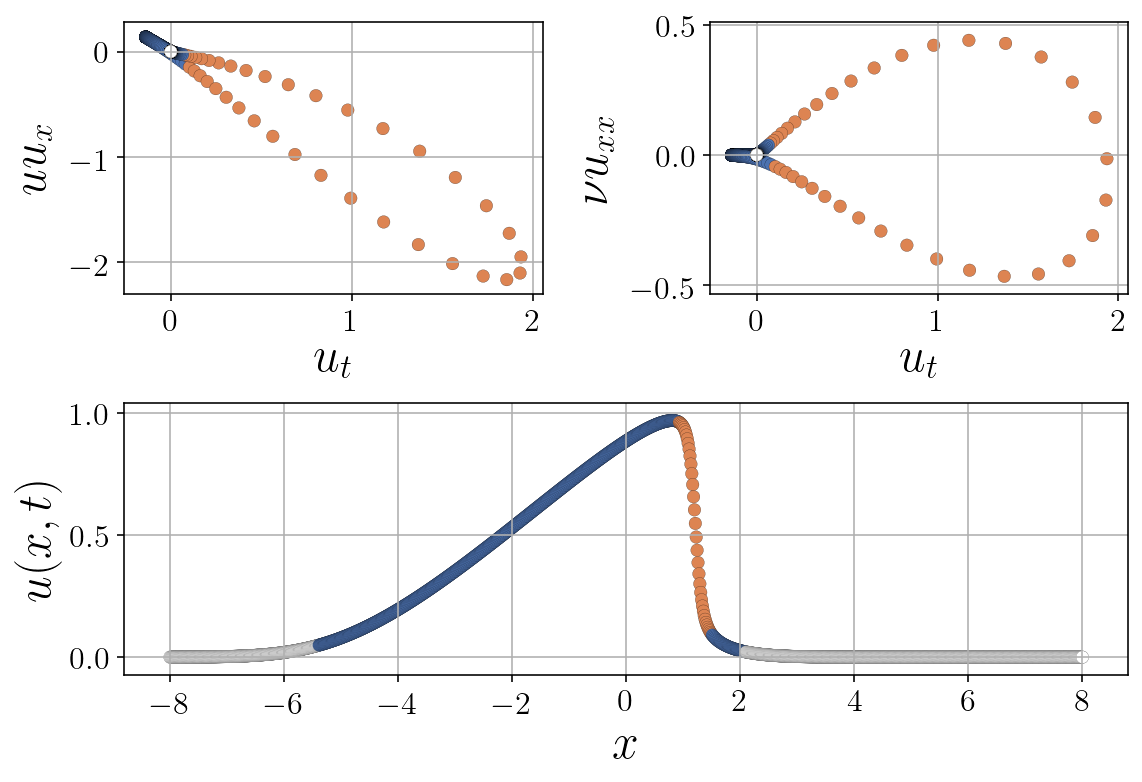

In [14]:
# Plot for one field

t_idx = 300
print(t[t_idx])

features = np.vstack([ut[:, t_idx], uux[:, t_idx], nu*uxx[:, t_idx]]).T
cluster_idx = model.predict(features)
# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])

s = 40 # Marker size
fontsize=24  # Size of axis labels
labelsize=16  # Size of tick labels

# 2D views of feature space
plt.figure(figsize=(9, 6))
plt.subplot(221)
plt.scatter(features[:, 0], features[:,1], s, balance_idx, cmap=cm, edgecolors='k', linewidth=0.1)
plt.ylabel('$u u_x$', fontsize=fontsize)
plt.xlabel('$u_t$', fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=labelsize)
plt.gca().tick_params(axis='both', which='minor', labelsize=labelsize)

plt.subplot(222)
plt.scatter(features[:, 0], features[:,2], s, balance_idx, cmap=cm, edgecolors='k', linewidth=0.1)
plt.ylabel(r'$\nu u_{xx}$', fontsize=fontsize)
plt.xlabel('$u_t$', fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=labelsize)
plt.gca().tick_params(axis='both', which='minor', labelsize=labelsize)

plt.subplot(212)
plt.scatter(x, u[:, t_idx], s, balance_idx, cmap=cm, edgecolors='k', linewidth=0.1)
plt.ylabel('$u(x, t)$', fontsize=fontsize)
plt.xlabel('$x$', fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=labelsize)
plt.gca().tick_params(axis='both', which='minor', labelsize=labelsize)

plt.subplots_adjust(wspace=0.4, hspace=0.4)